Course Reference: https://learn.microsoft.com/en-us/training/modules/intro-machine-learning-pytorch/
#### Learning objectives

In this module you will:

* Learn how create a asimple NN using pytorch

## Imports

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F 
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transformations

## Create a Fully Connected Network

We define our neural network by subclassing nn.Module, and initialize the neural network layers in __init__. Every nn.Module subclass implements the operations on input data in the forward method.

In [16]:
class NN(nn.Module):
    def __init__(self, input_size, n_classes):
        super(NN, self).__init__()

        self.fc1= nn.Linear(input_size, 50)
        self.fc2= nn.Linear(50, n_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return(x)

In [17]:
# check the network graph
model = NN(784, 10)

# create a random variable and pass it to the model to check the network graph
x = torch.randn(60, 784)
print(model(x).shape)

torch.Size([60, 10])


## Set device

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## HyperParameters

In [19]:
input_dim = 784
n_class = 10
learning_rate = 0.001
batch_size = 64
num_epochs = 1

## Load Data

In [20]:
# download and load the data from pytorch sample datasets
# https://pytorch.org/vision/0.8/datasets.html

train_dataset = datasets.MNIST(root='../dataset/', train=True, transform=transformations.ToTensor(), download=True)
train_datloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

Feature batch shape: torch.Size([64, 1, 28, 28])
Labels batch shape: torch.Size([64])


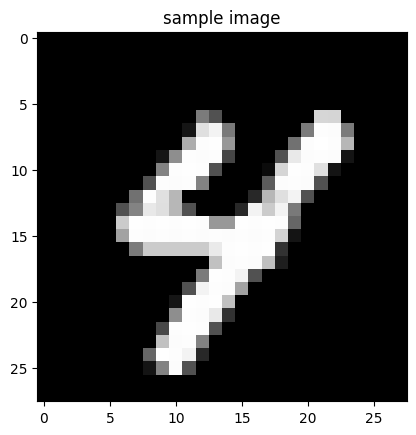

Label: 4


In [21]:
import matplotlib.pyplot as plt

# Understand the dataloader
plt.title('sample image')
# Display image and label.
train_features, train_labels = next(iter(train_datloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [22]:
# train data shape and class labels
print('train_dataset shape:', train_dataset.data.shape)
print(train_dataset.classes)

train_dataset shape: torch.Size([60000, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [23]:
test_dataset = datasets.MNIST(root='../dataset/', train=False, transform=transformations.ToTensor(), download=True)
test_datloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

print('test_dataset shape:', test_dataset.data.shape)
print(test_dataset.classes)

test_dataset shape: torch.Size([10000, 28, 28])
['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


## Initialise Network


In [24]:
model = NN(input_dim, n_class)
print(model)

NN(
  (fc1): Linear(in_features=784, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)


## Initialise Loss And Optimizer

In [25]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


## Train Network

#### Steps to train the model
1. For each epoch, iterate through the batch
2. For each batch
    * feed forward the input and target data of train to the model
    * Calculate the loss and score
    * Backpropogate the loss
    * optimise the loss using optimiser() (gradient descent is one such optimiser) 


In [26]:
%%time

# get model to cuda if possible
model = model.to(device)

for epoch in range(num_epochs):
    for batch_idx, (data, target) in enumerate((train_datloader)):

        # get data to cuda if possible
        data = data.to(device)
        target = target.to(device)

        data = data.reshape(-1,784)

        # feed forward the data to model
        scores = model(data)
        loss = criterion(scores, target)
        print(f"epoch: {epoch}, batch: {batch_idx}, loss: {loss}")
        
        # Backpropagation
        optimizer.zero_grad() # This will flush the gradients from the last iteration
        loss.backward()

        # optimise the loss (gradient descent or Adam step)
        optimizer.step()


epoch: 0, batch: 0, loss: 2.323420286178589
epoch: 0, batch: 1, loss: 2.295718193054199
epoch: 0, batch: 2, loss: 2.230379819869995
epoch: 0, batch: 3, loss: 2.236008644104004
epoch: 0, batch: 4, loss: 2.230621814727783
epoch: 0, batch: 5, loss: 2.151639461517334
epoch: 0, batch: 6, loss: 2.1377763748168945
epoch: 0, batch: 7, loss: 2.1138293743133545
epoch: 0, batch: 8, loss: 2.072591543197632
epoch: 0, batch: 9, loss: 2.054612874984741
epoch: 0, batch: 10, loss: 2.056401014328003
epoch: 0, batch: 11, loss: 2.0291805267333984
epoch: 0, batch: 12, loss: 1.9473990201950073
epoch: 0, batch: 13, loss: 1.9610120058059692
epoch: 0, batch: 14, loss: 1.8364129066467285
epoch: 0, batch: 15, loss: 1.8503538370132446
epoch: 0, batch: 16, loss: 1.821225881576538
epoch: 0, batch: 17, loss: 1.7982161045074463
epoch: 0, batch: 18, loss: 1.7077645063400269
epoch: 0, batch: 19, loss: 1.775176763534546
epoch: 0, batch: 20, loss: 1.776419758796692
epoch: 0, batch: 21, loss: 1.7028098106384277
epoch: 0, 

## Check accuracy on train and test data (Validate model accuracy)

In [27]:
# Check accuracy on training & test to see how good our model
def check_accuracy(loader, model):
    """
    Check accuracy of our trained model given a loader and a model

    Parameters:
        loader: torch.utils.data.DataLoader
            A loader for the dataset you want to check accuracy on
        model: nn.Module
            The model you want to check accuracy on

    Returns:
        acc: float
            The accuracy of the model on the dataset given by the loader
    """

    num_correct = 0
    num_samples = 0
    model.eval()

    # We don't need to keep track of gradients here so we wrap it in torch.no_grad()
    with torch.no_grad():
        # Loop through the data
        for x, y in loader:

            # Move data to device
            x = x.to(device=device)
            y = y.to(device=device)

            # Get to correct shape
            x = x.reshape(x.shape[0], -1)

            # Forward pass
            scores = model(x)
            predictions = scores.argmax(1)

            # Check how many we got correct
            num_correct += (predictions == y).sum()

            # Keep track of number of samples
            num_samples += predictions.size(0)

    model.train()
    return num_correct / num_samples

In [28]:
# Check accuracy on training & test to see how good our model
print(f"Accuracy on training set: {check_accuracy(train_datloader, model)*100:.2f}")
print(f"Accuracy on test set: {check_accuracy(test_datloader, model)*100:.2f}")

Accuracy on training set: 93.26
Accuracy on test set: 93.27


End